In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [3]:
def get_pickles(): 
    x_train = pickle.load(open(f'../data/processed/pickles/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../data/processed/pickles/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../data/processed/pickles/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../data/processed/pickles/y_test.p', 'rb'))
    X = pickle.load(open('../data/processed/pickles/X.p', 'rb'))
    y = pickle.load(open('../data/processed/pickles/y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()


print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')

y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 
         'population', 'time_passed']] = standard.fit_transform(x_train[['amount_tsh', 
                                                                         'gps_height', 'population', 'time_passed']])

Original X: (57247, 53)	Original y: (57247, 1)
Train X: (38090, 53)	Train y: (38090, 1)
Test X: (8588, 53)	Test y: (8588, 1)


### Baseline Testing for Models and Stacked

In [4]:


models = {'log': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
           'LinearSVC': LinearSVC(max_iter = 1250), 'SDGSVC': SGDClassifier(),  
          'ada': AdaBoostClassifier(), 
            'Bagging': BaggingClassifier(), 'ridge': RidgeClassifier(), 
          'rf': RandomForestClassifier(),
        }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
    scores = cross_val_score(m, X, y, scoring = 'accuracy', cv = cv, n_jobs = 14, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)
    

Evaluating STACKED: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [29:47<00:00, 148.98s/it]


In [6]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../models/VanillaResults.p', 'wb'))

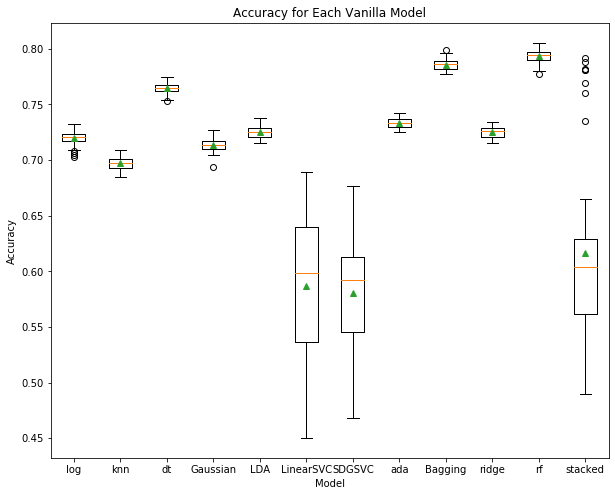

In [7]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()